AVG:66.3971 Hz


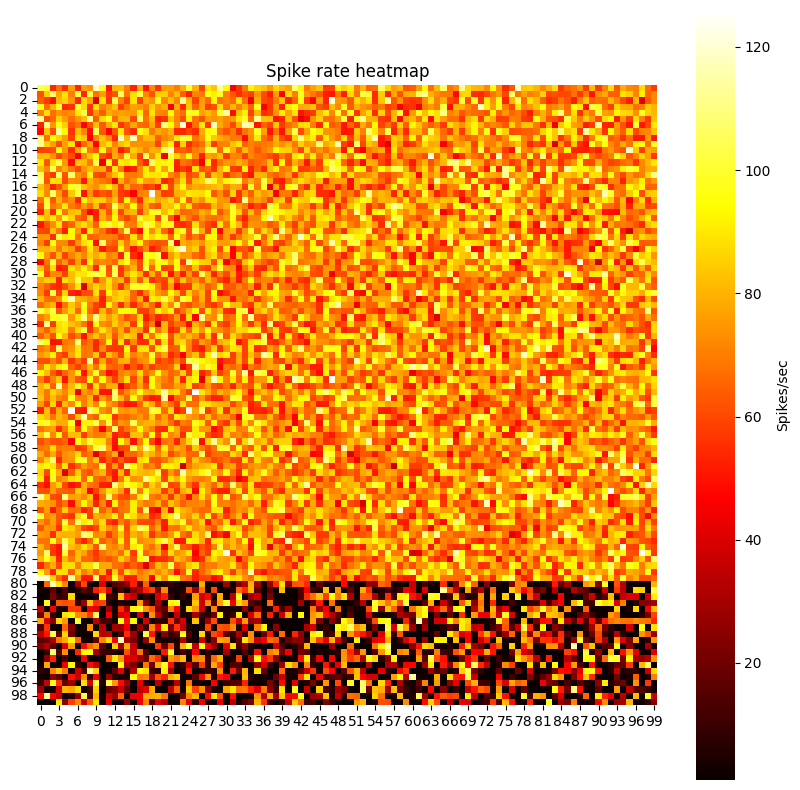

[[105. 101.  54. ...  88.  67.  58.]
 [ 62.  85. 106. ...  92.  65.  72.]
 [ 64.  57.  49. ...  41.  63.  72.]
 ...
 [ 28.   2.   3. ...  14.   9.   2.]
 [ 47. 112.  46. ...   1.  98.  36.]
 [  1.   1.   1. ...   3.  10.  23.]] Hz


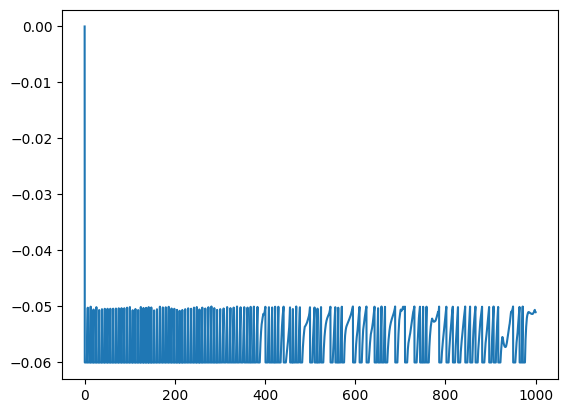

In [1]:
from brian2 import *
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1*second # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')

Pe = neurons[:NE]
Pi = neurons[NE:]
# ###########################################
# Connecting the network
# ###########################################

con_e = Synapses(Pe, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(p=epsilon)
con_ii = Synapses(Pi, Pi, on_pre='g_gaba += 3*nS')
con_ii.connect(p=epsilon)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
con_ie = Synapses(Pi, Pe, model=eqs_stdp_inhib,
                  on_pre='''Apre += 1.
                         w = clip(w+(Apost-alpha)*eta, 0, gmax)
                         g_gaba += w*nS''',
                  on_post='''Apost += 1.
                          w = clip(w+Apre*eta, 0, gmax)
                       ''')

con_ie.connect(p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run without plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime)
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 3s
AVG:66.4436 Hz


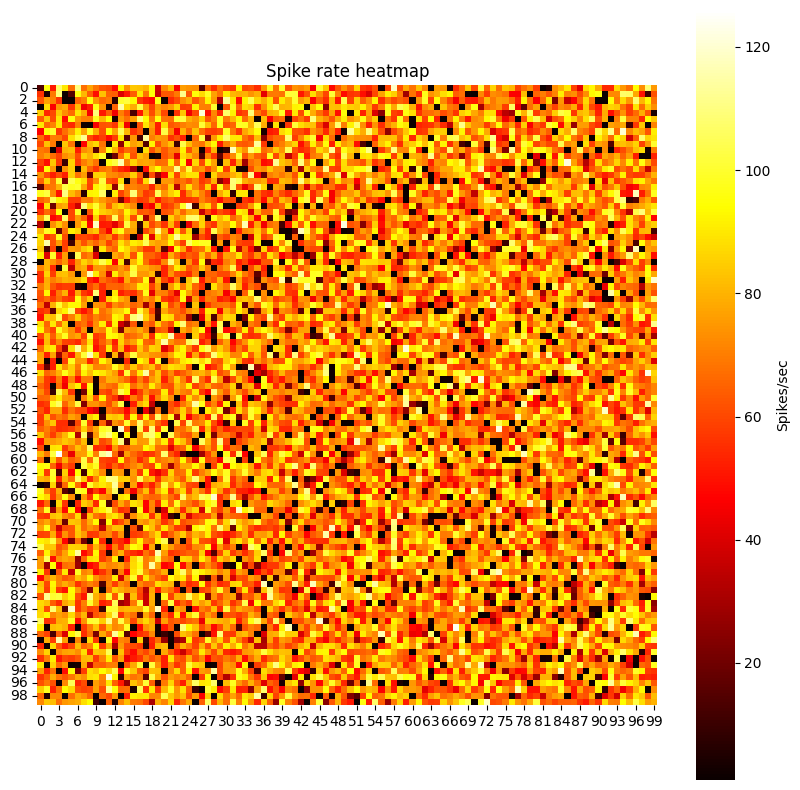

[[ 14.  96.  51. ...  73. 108.  75.]
 [ 56.   4.  69. ...  50.  11.  62.]
 [ 63.  77.  71. ...  81.  93.  68.]
 ...
 [ 85.  98.  53. ...  93.   1.  73.]
 [ 65.   5.  72. ...  84.  63.  82.]
 [ 72.  84.  82. ...  88.  76.  80.]] Hz


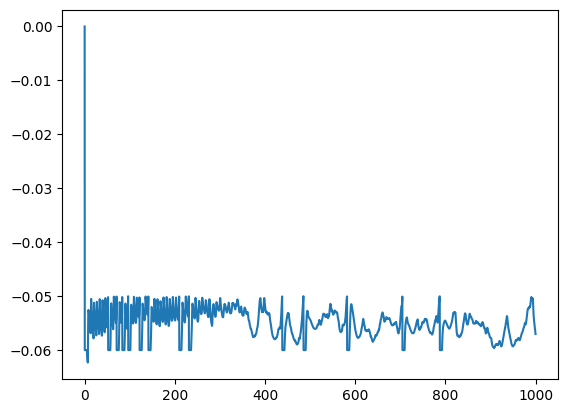

In [2]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 3s
AVG:67.573 Hz


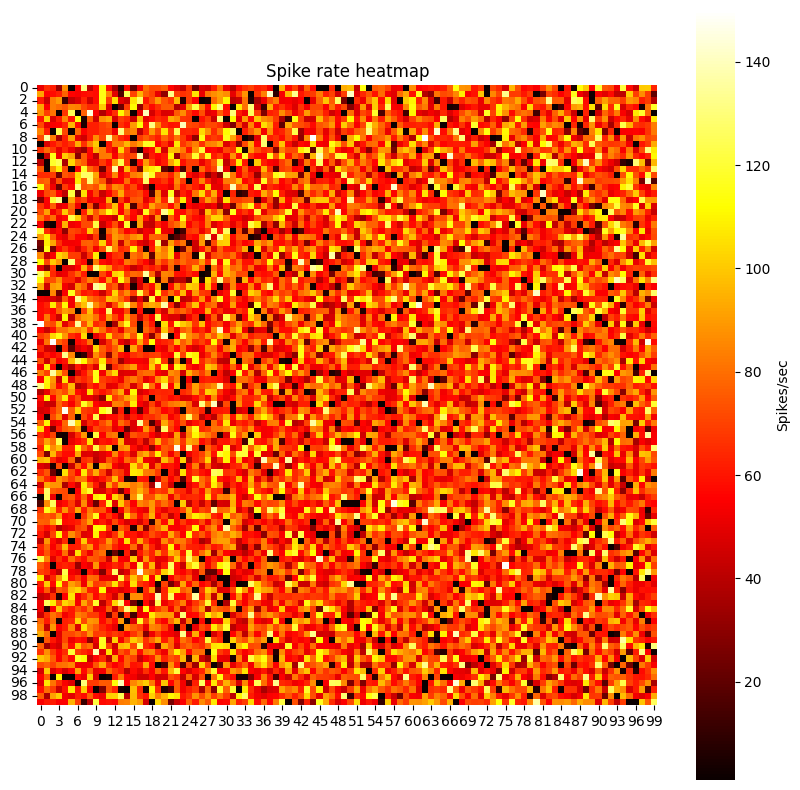

[[ 51.  65.  61. ... 100. 101.  63.]
 [ 92.  56.  58. ...  86.  68.  20.]
 [ 61.  44.  83. ...  62.  68.  39.]
 ...
 [ 59.  80.  69. ...  90.  16.  62.]
 [ 76.  37.  91. ...  48.  55.  93.]
 [ 54.  60.  61. ...  99.  74. 125.]] Hz


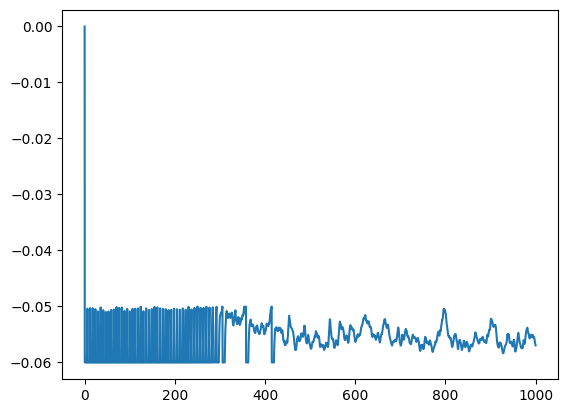

In [3]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
syn_poisson = Synapses(P, neurons, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
89. ms (8%) simulated in 10s, estimated 1m 42s remaining.
175.9 ms (17%) simulated in 20s, estimated 1m 34s remaining.
263.1 ms (26%) simulated in 30s, estimated 1m 24s remaining.
0.3422 s (34%) simulated in 40s, estimated 1m 17s remaining.
0.4218 s (42%) simulated in 50s, estimated 1m 9s remaining.
0.5006 s (50%) simulated in 1m 0s, estimated 1m 0s remaining.
0.5742 s (57%) simulated in 1m 10s, estimated 52s remaining.
0.6524 s (65%) simulated in 1m 20s, estimated 43s remaining.
0.731 s (73%) simulated in 1m 30s, estimated 33s remaining.
0.8097 s (80%) simulated in 1m 40s, estimated 24s remaining.
0.8885 s (88%) simulated in 1m 50s, estimated 14s remaining.
0.9705 s (97%) simulated in 2m 0s, estimated 4s remaining.
1. s (100%) simulated in 2m 3s
AVG:200. Hz


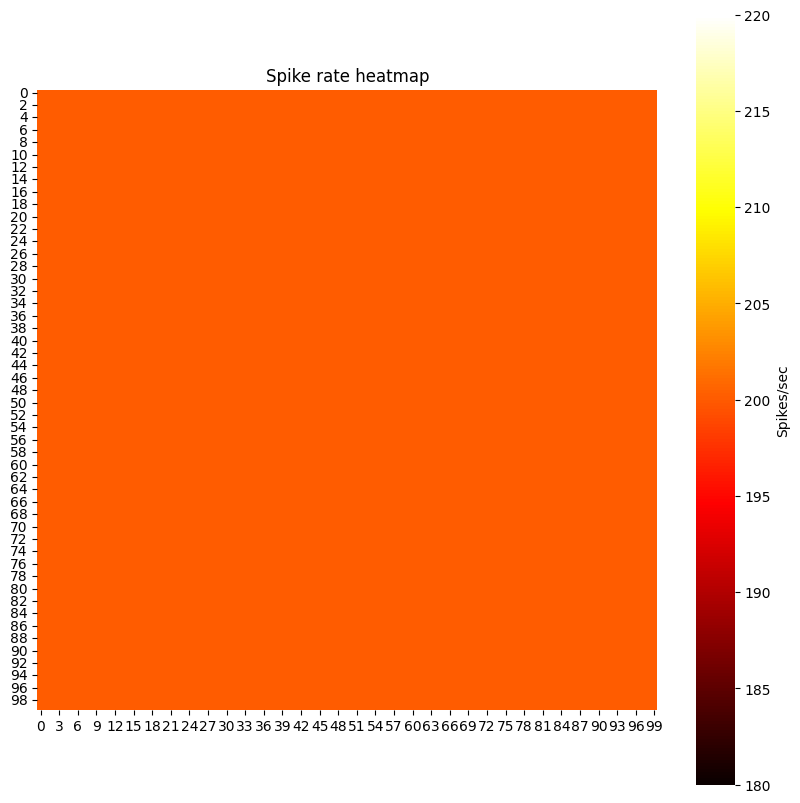

[[200. 200. 200. ... 200. 200. 200.]
 [200. 200. 200. ... 200. 200. 200.]
 [200. 200. 200. ... 200. 200. 200.]
 ...
 [200. 200. 200. ... 200. 200. 200.]
 [200. 200. 200. ... 200. 200. 200.]
 [200. 200. 200. ... 200. 200. 200.]] Hz


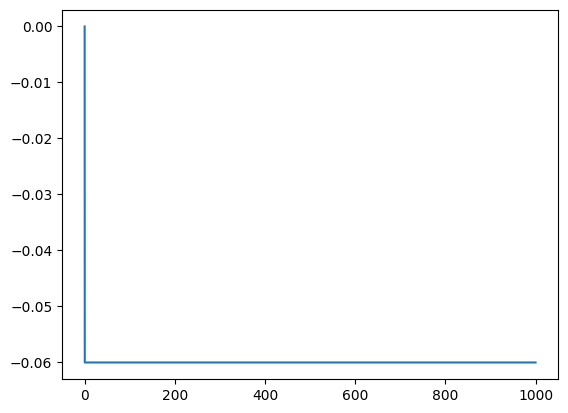

In [4]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10000*Hz)
syn_poisson = Synapses(P, neurons, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

In [5]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:1000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10000*Hz)
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

IndexError: Illegal start/end values for subgroup, 1000>=1000

4000000
Starting simulation at t=0. s for a duration of 1. s
0.9686 s (96%) simulated in 10s, estimated < 1s remaining.
1. s (100%) simulated in 10s
AVG:52.3913 Hz


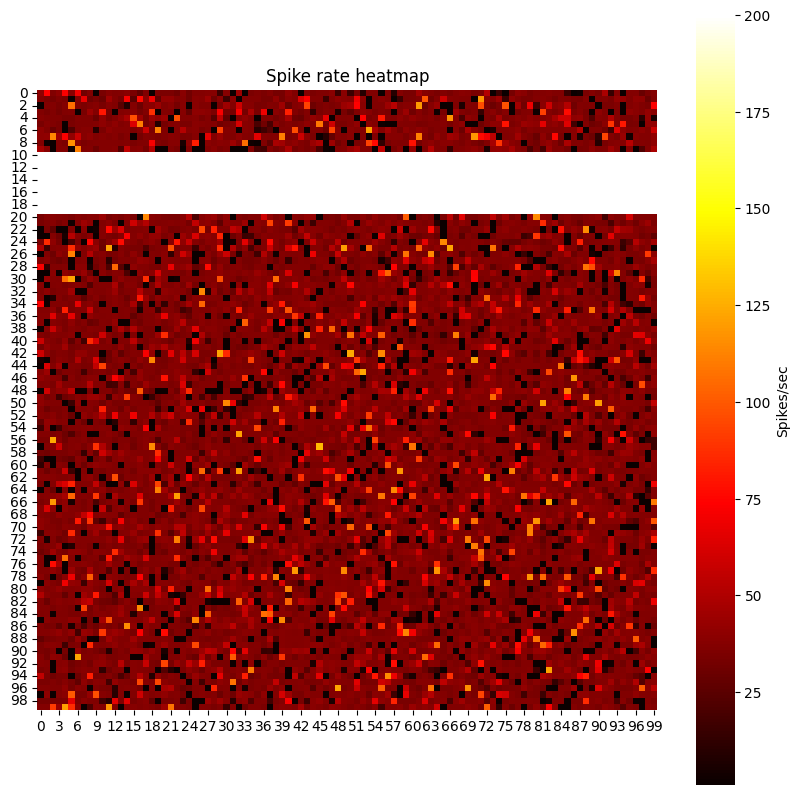

[[40. 74. 36. ... 29. 35. 37.]
 [37. 35. 33. ... 40. 30. 36.]
 [ 1. 36. 37. ... 36. 35. 73.]
 ...
 [ 1. 40.  2. ... 37. 36. 38.]
 [33. 33. 34. ...  1. 37. 35.]
 [37. 37. 91. ...  1. 38. 36.]] Hz


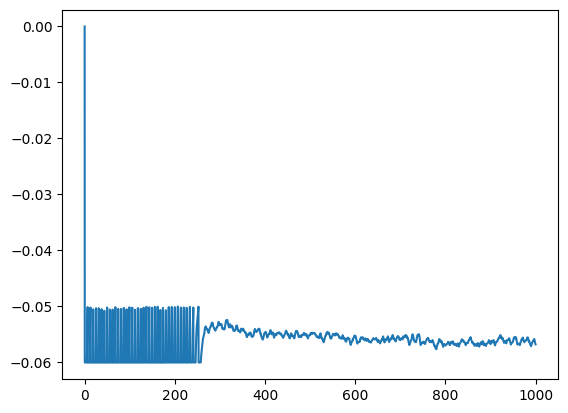

In [6]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10000*Hz)
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 3s
AVG:51.9355 Hz


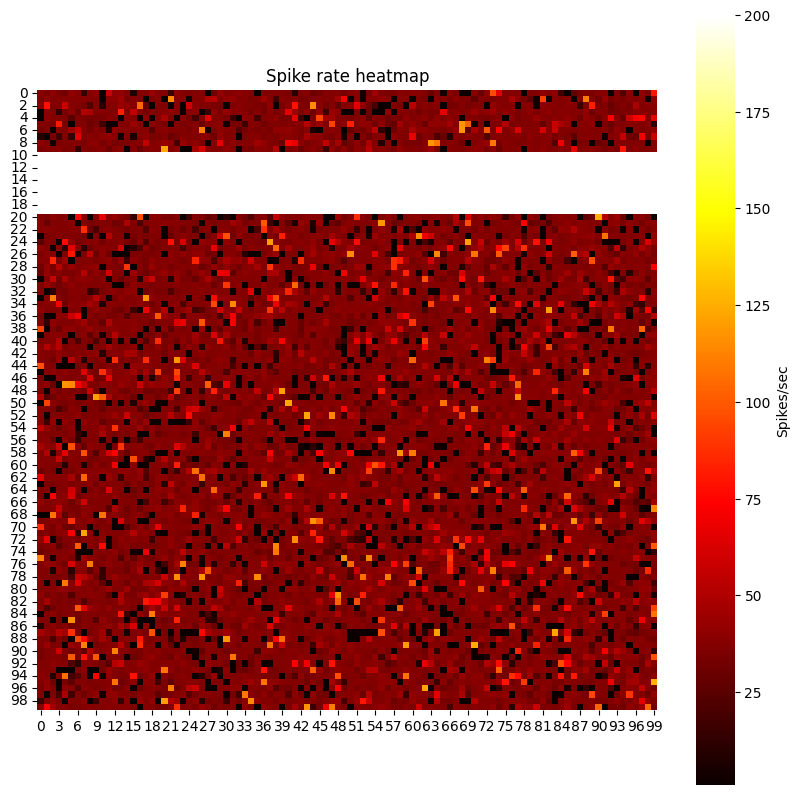

[[ 39.  35.  40. ...  41.  35.  81.]
 [ 35.  40.  36. ...  39.   4.  40.]
 [ 37.  78.  37. ...  36.  39.  38.]
 ...
 [ 37.   1.  36. ...  37.  31.  41.]
 [ 16.  35.  40. ...  64.  41.  35.]
 [ 37.  70.  46. ...  44. 105.  32.]] Hz


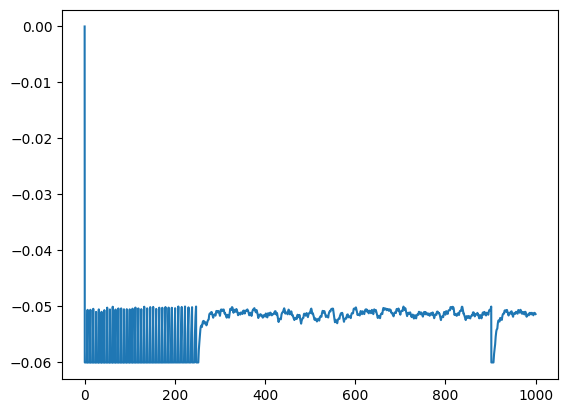

In [7]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=1000*Hz)
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
AVG:51.9005 Hz


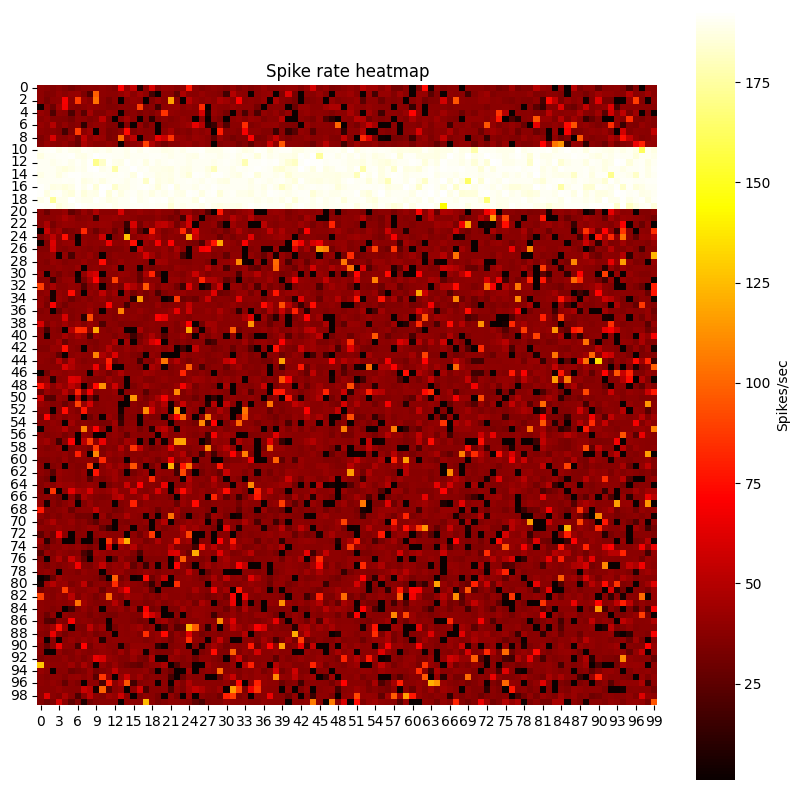

[[39. 37. 36. ...  1. 37. 37.]
 [39. 35. 36. ... 37. 44. 37.]
 [39. 33. 38. ... 36.  3. 39.]
 ...
 [37. 37. 38. ... 37. 37. 32.]
 [38. 62. 38. ... 61. 40. 39.]
 [35. 30. 34. ... 40. 33. 95.]] Hz


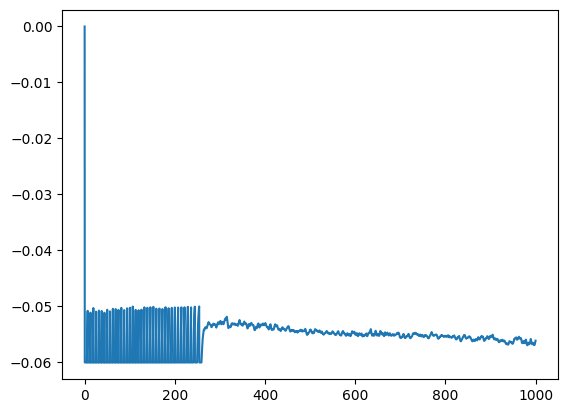

In [8]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=100*Hz)
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
AVG:56.7741 Hz


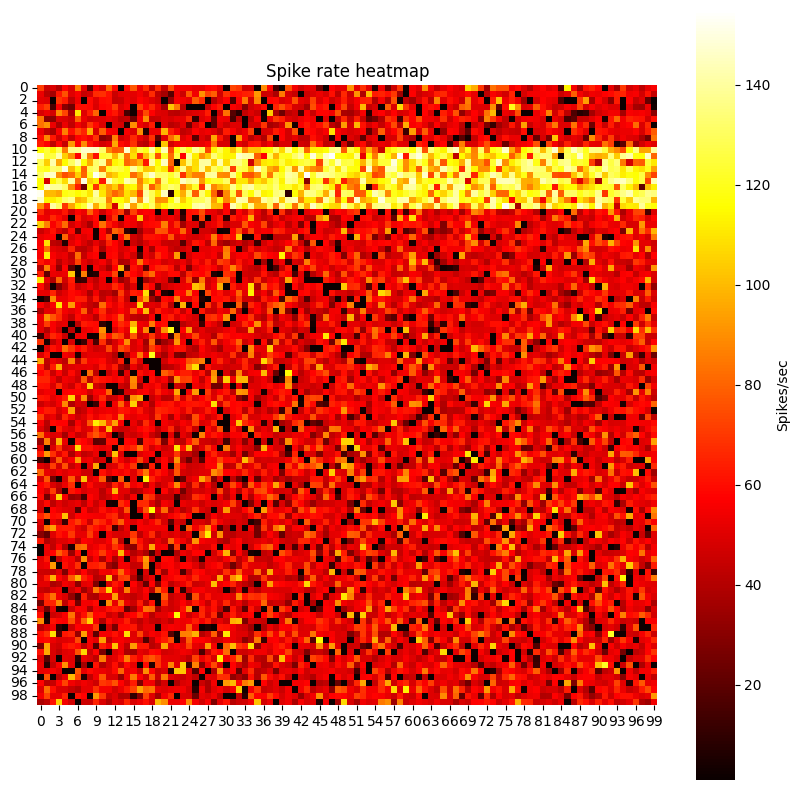

[[71. 45. 49. ... 42. 52. 56.]
 [53. 41. 36. ... 47. 61. 44.]
 [51. 50.  1. ... 50. 22.  1.]
 ...
 [50. 82. 60. ... 63. 74. 58.]
 [55. 73. 51. ... 49. 52. 92.]
 [38. 43. 61. ... 39. 35. 54.]] Hz


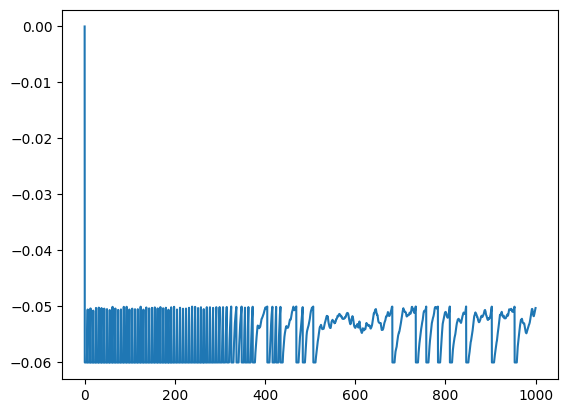

In [9]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

In [10]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect()
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
syn_poisson.w[i, j] = 0
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s


AttributeError: No attribute with name w

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in < 1s
AVG:63.9372 Hz


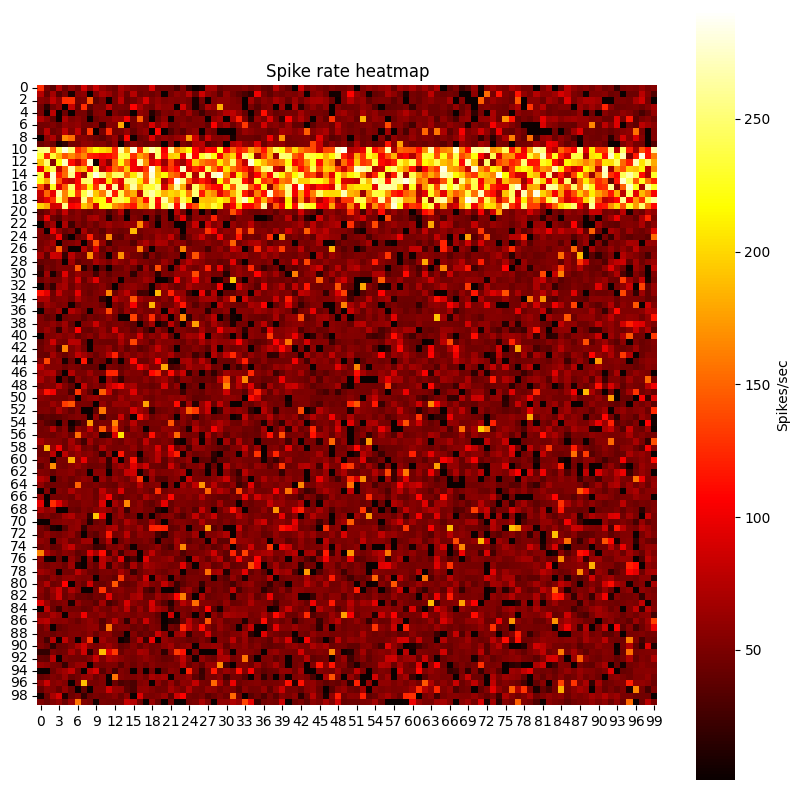

[[125.  47.  35. ...  60.  49.  54.]
 [ 75.  40.  67. ...  78.  52.  32.]
 [ 57.  53.  79. ...  85.  47.   1.]
 ...
 [ 41.  56.  54. ...  48.  26.  51.]
 [  6.  44.  70. ...  46.  46.   2.]
 [ 51.  43.  52. ...  45.  76.  49.]] Hz


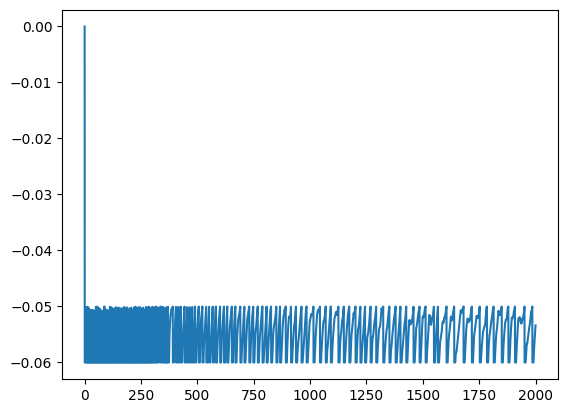

In [11]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
Test=True
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect(condition='Test')
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
Test=False
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 1s
AVG:32.93405 s


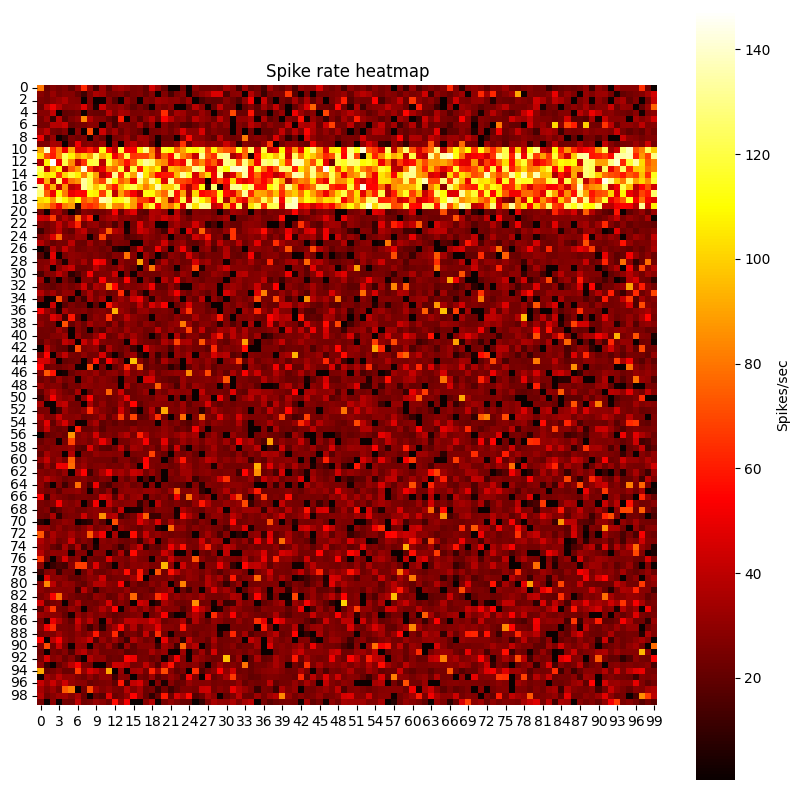

[[80.5 21.5 27.  ... 64.  22.5  0.5]
 [28.5 23.5 32.  ... 27.  34.5 44.5]
 [25.5 23.5 28.  ...  0.5 24.5 41.5]
 ...
 [34.5 26.5 32.5 ... 26.5 34.5 37. ]
 [37.5 23.  27.5 ... 85.  67.  39. ]
 [24.   0.5 29.  ... 17.5 24.  18.5]] s


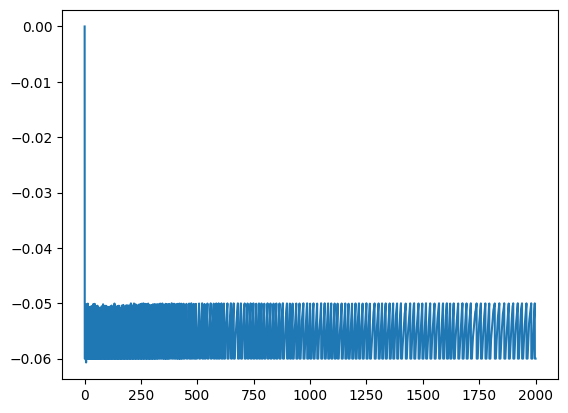

In [12]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
Test=True
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect(condition='Test')
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
Test=False
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 2*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=1. s for a duration of 10. s
10. s (100%) simulated in 9s
AVG:51.99845 s


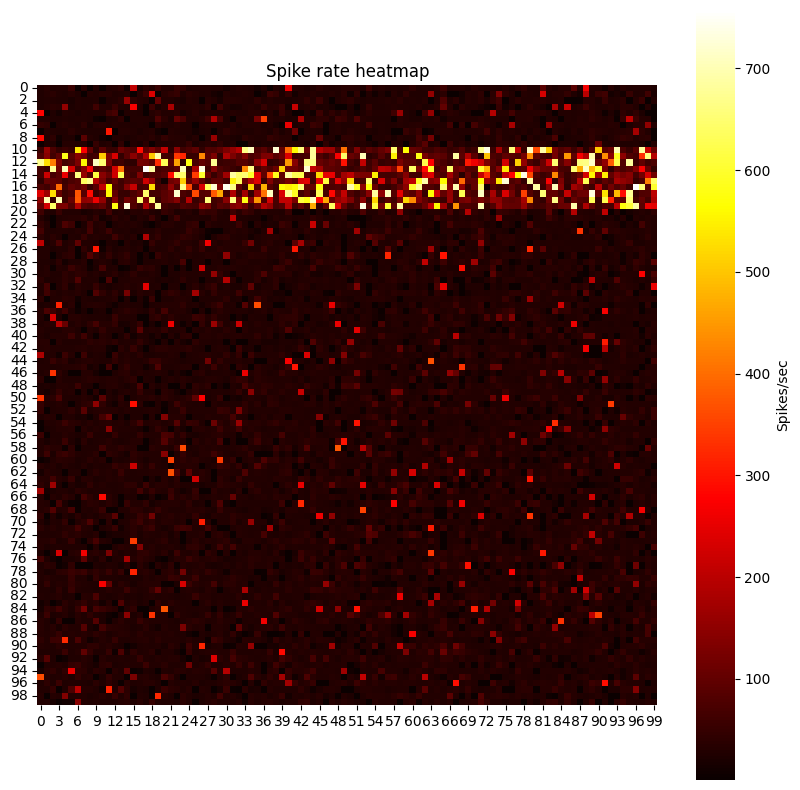

[[27.  34.  26.5 ... 28.5 29.5 23.5]
 [24.5 30.5 37.  ... 29.5 60.5 21. ]
 [25.  29.  28.5 ... 52.5  0.5 29. ]
 ...
 [29.5 29.5 45.  ... 26.5 28.5 26.5]
 [31.   0.5 32.5 ...  0.5 28.   0.5]
 [30.  28.  18.  ... 25.  31.  26.5]] s


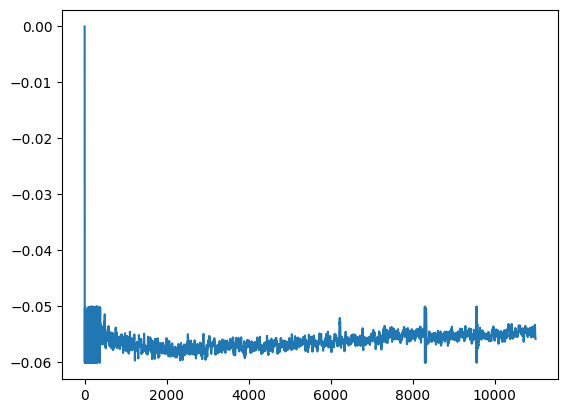

In [13]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
Test=True
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect(condition='Test')
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
Test=False
run(10*simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 2*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=1. s for a duration of 10. s
10. s (100%) simulated in 9s
AVG:104.7212 Hz


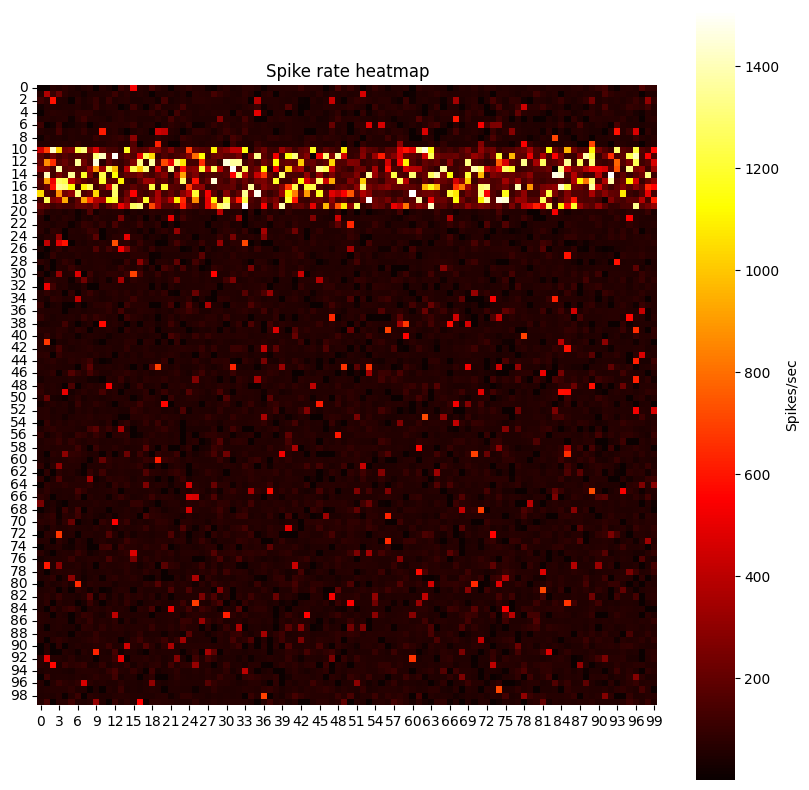

[[  1.   1.  71. ... 150.  95.  84.]
 [ 56. 372. 107. ...   1.  53.  52.]
 [110.  72. 585. ...  60. 302.  86.]
 ...
 [ 59.  64.  60. ... 131.  69.   8.]
 [ 53.  56.  53. ...  56.  70.  67.]
 [ 60. 126.   1. ...  57. 102.  49.]] Hz


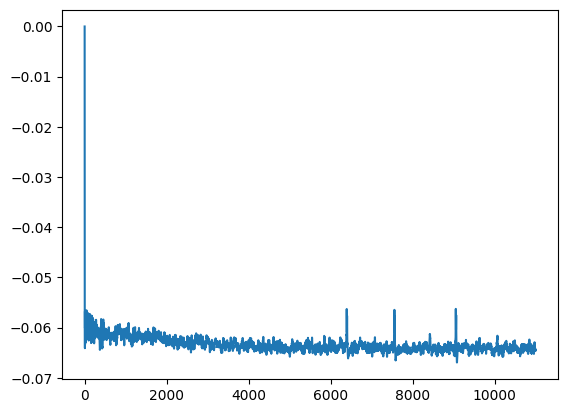

In [14]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
Test=True
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect(condition='Test')
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
Test=False
e=0
run(10*simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in < 1s
AVG:63.3996 Hz


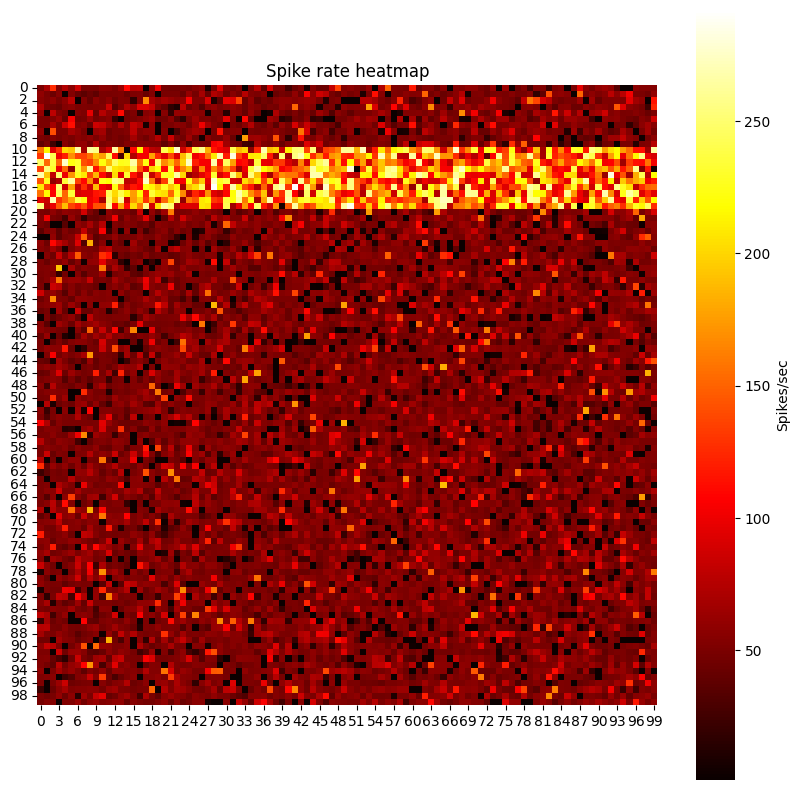

[[ 51.  70. 125. ...  54.  54.  54.]
 [ 60.  50.  44. ...  51.  46.  59.]
 [ 56.  52.  58. ...  60.   1. 115.]
 ...
 [ 22.   1.  44. ...  53.  49.  56.]
 [ 51.  46.  49. ...  57.  63.  49.]
 [ 48.  55.  54. ...  62.  49.  58.]] Hz


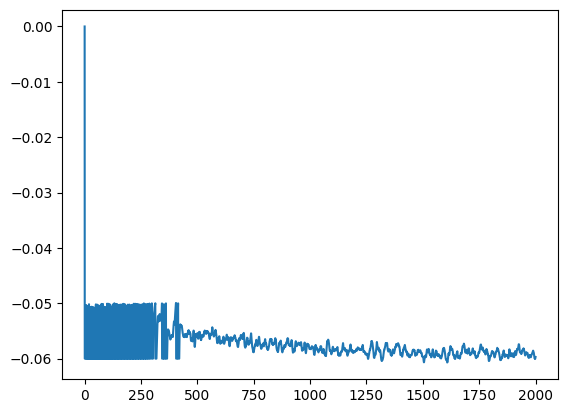

In [15]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
Test=True
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect(condition='Test')
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
Test=False
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 2s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in < 1s
AVG:62.1764 Hz


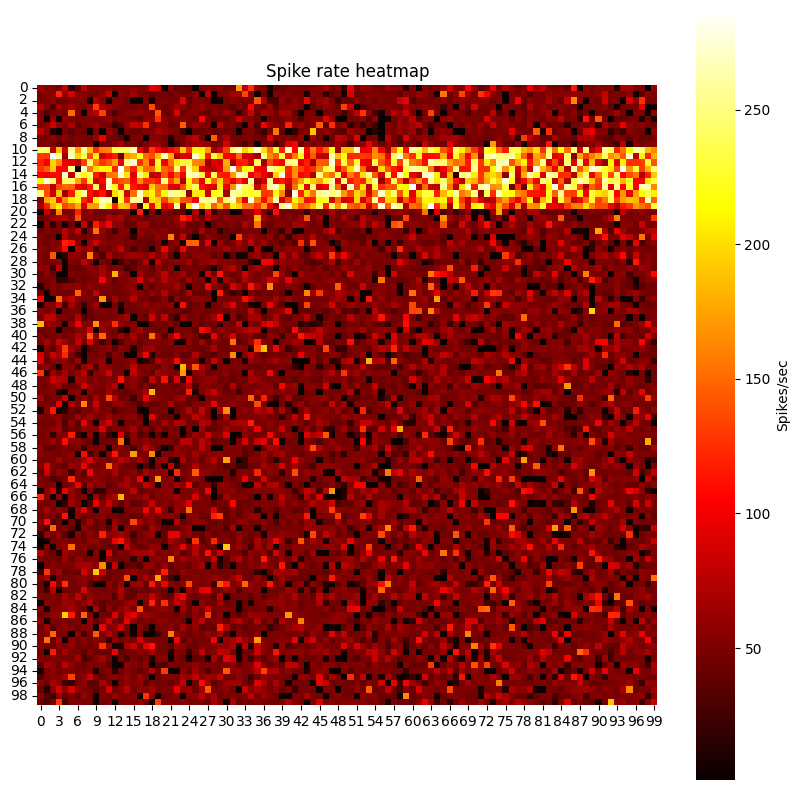

[[ 63.  52.  54. ...  51.   2.  61.]
 [ 49.  56.  54. ...  37.  56.  49.]
 [ 45.  51.  61. ... 124.  49.  46.]
 ...
 [ 42.  12.  53. ...  51.  49.  64.]
 [ 55.  33.  23. ...  56.  21.  53.]
 [ 42.  31.  45. ...  22.  54.  79.]] Hz


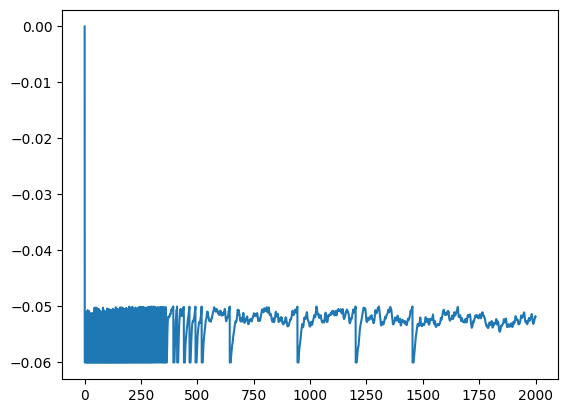

In [16]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
P = PoissonGroup(int(NE*0.1), rates=10*Hz)
Test=True
syn_poisson = Synapses(P, cellassembly, on_pre='g_ampa += 0.3*nS')
syn_poisson.connect(condition='Test')
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

In [17]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000


DimensionMismatchError: The provided weight does not have the same unit as the target variable 'v' (units are 1 and V).

In [18]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=1
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000


DimensionMismatchError: The provided weight does not have the same unit as the target variable 'v' (units are 1 and V).

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 5s
AVG:66.2361 Hz


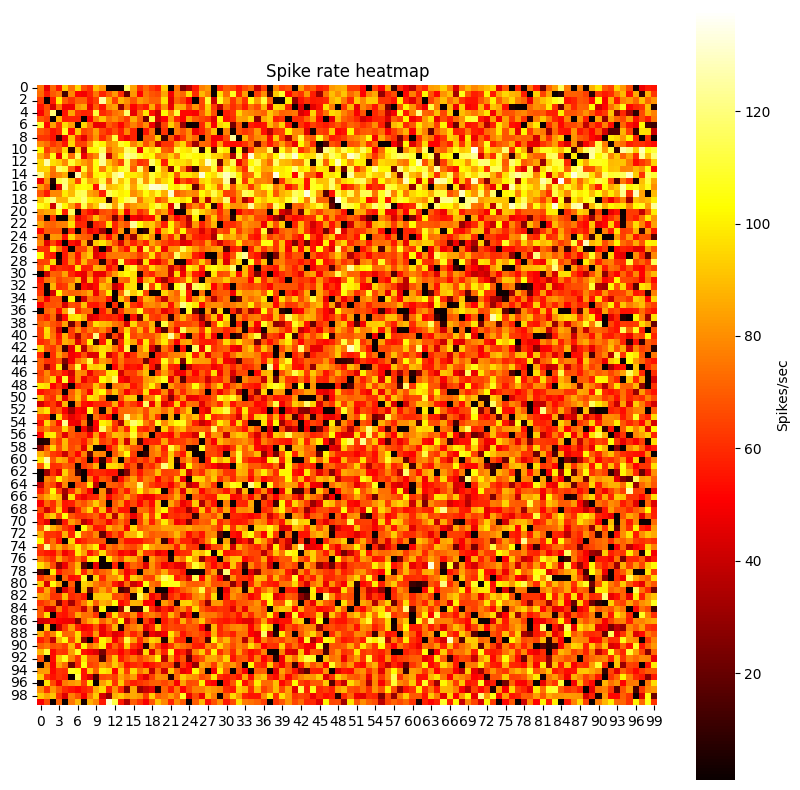

[[ 75.  47.  72. ...  48.  56.  54.]
 [ 73.  56.  69. ...  10.  87.  62.]
 [ 63.   1.  57. ...  90.  72.  81.]
 ...
 [ 80.  61.  82. ...  63.  79.  81.]
 [ 93.  84.  91. ...  44. 105.  21.]
 [ 50.  66.   2. ...  72. 106.  61.]] Hz


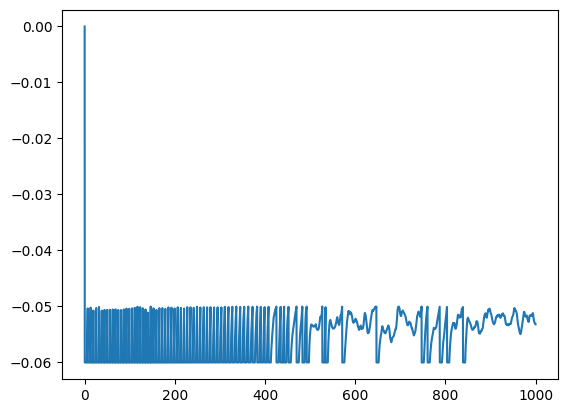

In [19]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 3s
AVG:80.8273 Hz


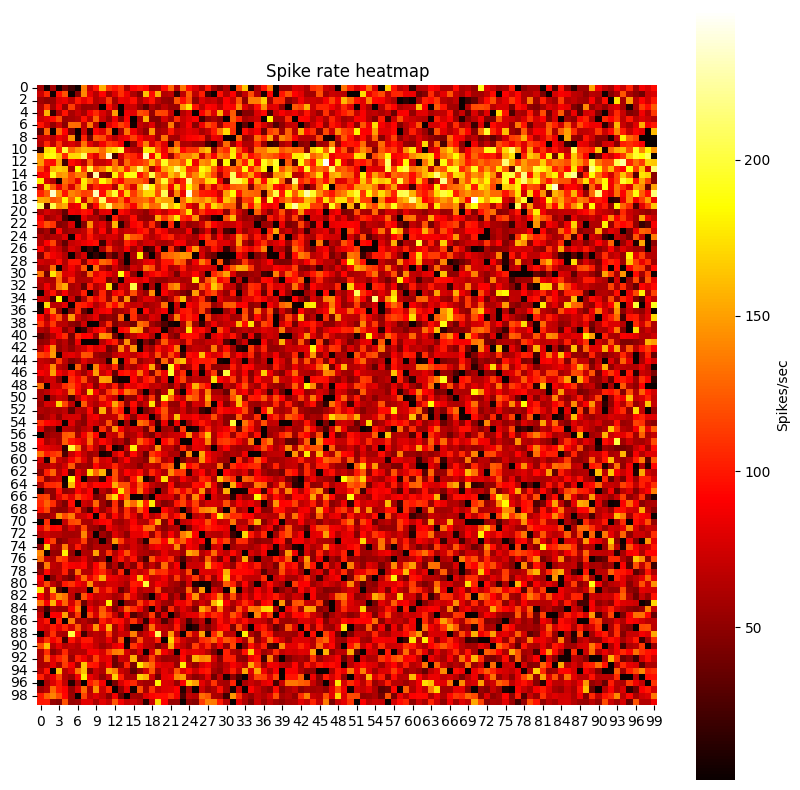

[[ 58.   5.  57. ...  87.  78.  94.]
 [ 72. 106.   3. ...  39.  73.  78.]
 [ 56.  50.  54. ...  92.  74.  99.]
 ...
 [ 56.  67. 130. ...  90. 100.  76.]
 [100. 127. 139. ...  73.  79. 135.]
 [ 99. 100.  53. ...  63.  63.  86.]] Hz


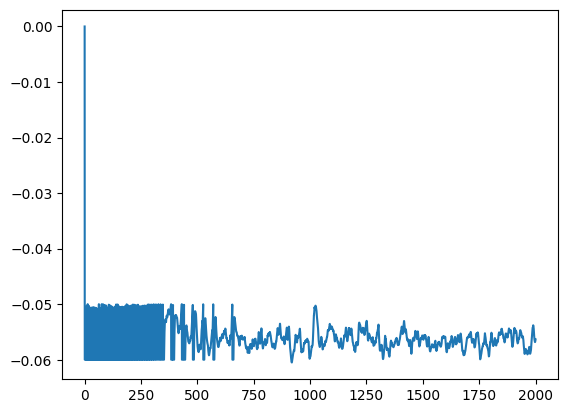

In [20]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
we=0*mV
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 6s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 2s
AVG:40.36625 s


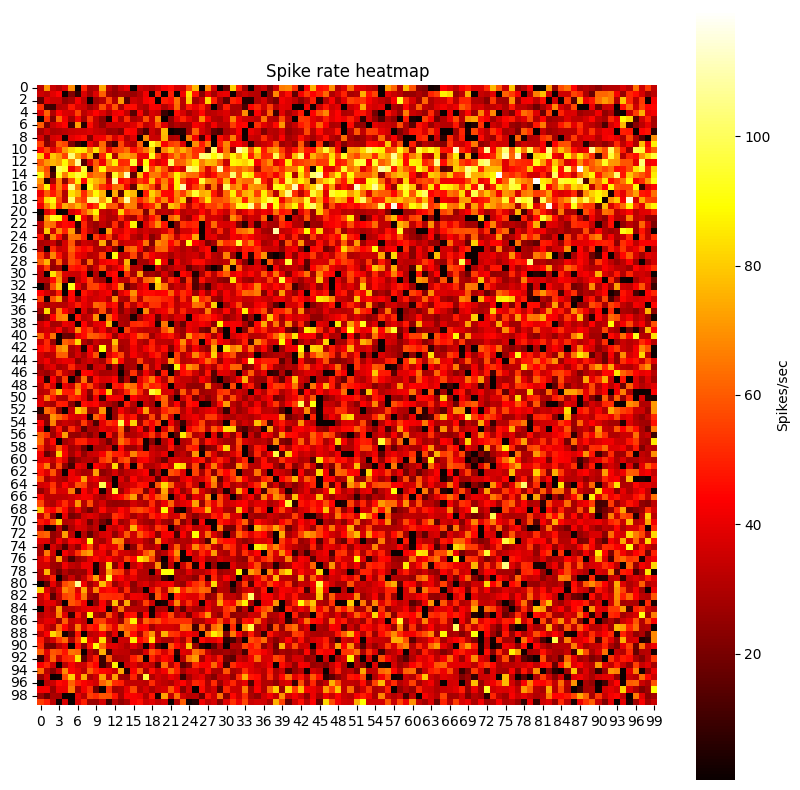

[[31.5 70.  34.  ... 35.  53.5 33.5]
 [35.  32.5 39.  ... 36.5 26.5 32. ]
 [16.  39.  35.  ... 53.5  1.5 42.5]
 ...
 [42.5 43.  26.5 ... 21.  27.  90. ]
 [26.5 17.5 29.  ... 39.5 24.  27.5]
 [54.5 48.5 32.5 ... 43.  27.5 34. ]] s


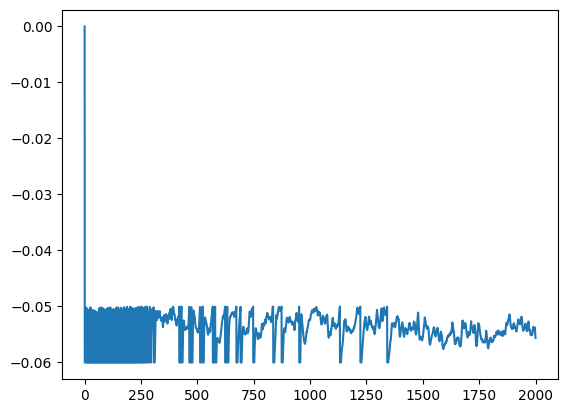

In [21]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
we=0*mV
run(simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 2*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 6s
Starting simulation at t=1. s for a duration of 3. s
3. s (100%) simulated in 7s
AVG:46.6333 s


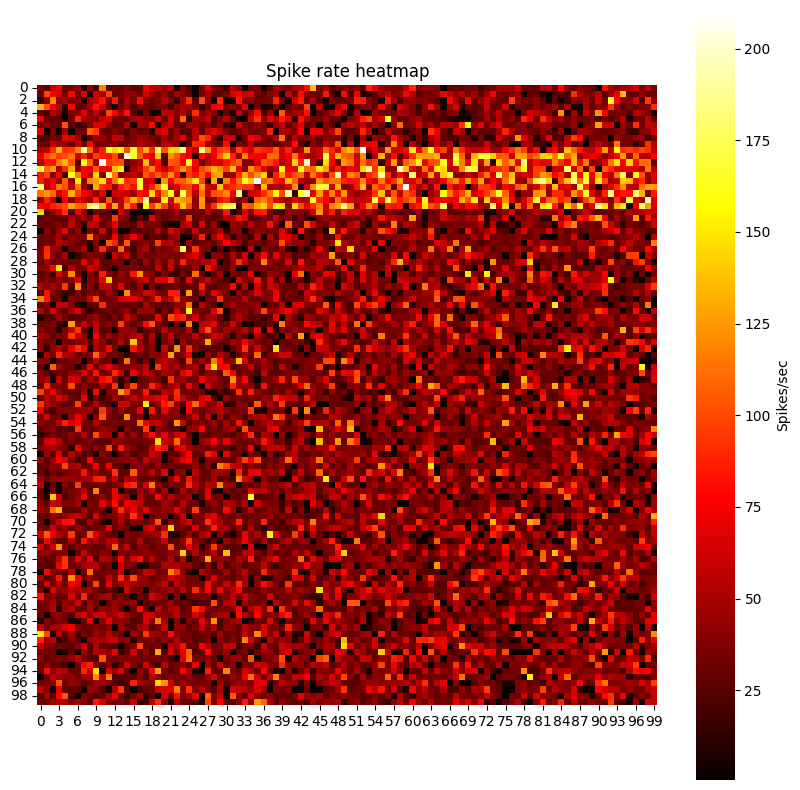

[[ 35.   26.   58.  ...  33.5  53.   33. ]
 [ 31.5  98.5  73.5 ...  44.   30.5  29.5]
 [ 12.   40.  119.  ...  22.5  95.5  38.5]
 ...
 [ 58.5  42.    0.5 ...  33.5  53.5  62.5]
 [ 20.5  49.5  27.  ...  40.   34.   59.5]
 [ 33.5  30.   48.  ...   1.   65.   55.5]] s


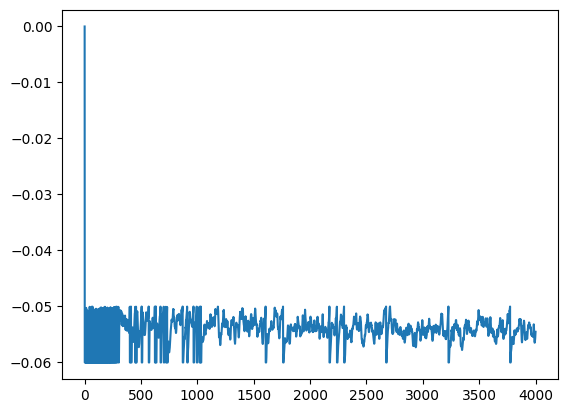

In [22]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
we=0*mV
run(3*simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 2*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 5s
Starting simulation at t=1. s for a duration of 3. s
3. s (100%) simulated in 7s
AVG:25.299375 s


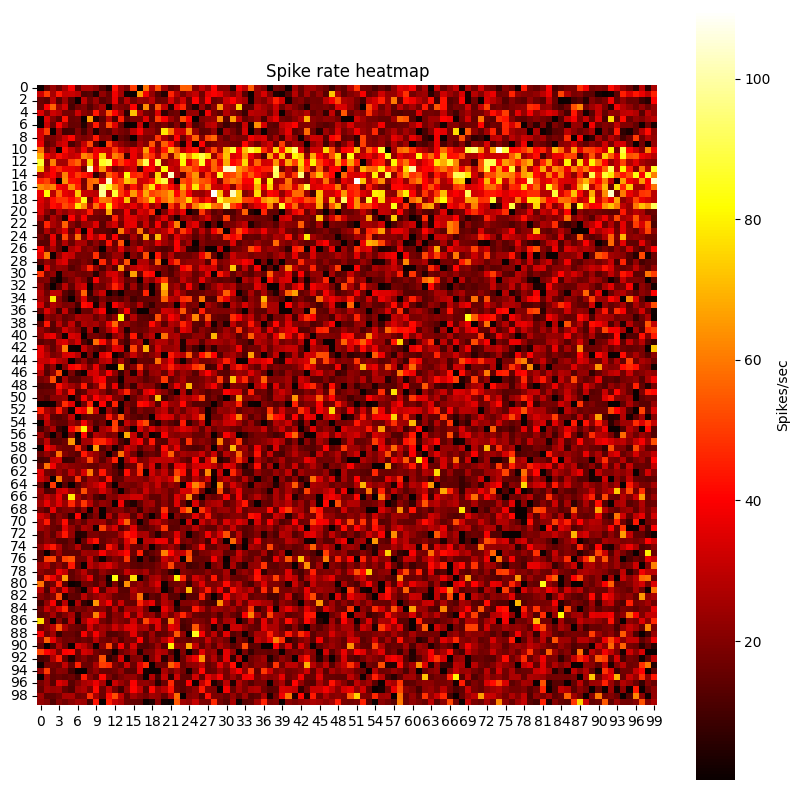

[[ 0.25 15.   24.   ... 29.25  6.   26.  ]
 [31.75 49.5  25.5  ... 37.25 29.75 45.5 ]
 [16.   13.5  29.75 ...  8.5   4.75 40.  ]
 ...
 [15.25 25.25 23.75 ...  0.25 16.   22.25]
 [25.   14.   14.5  ... 21.25  1.5  22.75]
 [22.75 20.   12.   ... 53.5  20.25 26.5 ]] s


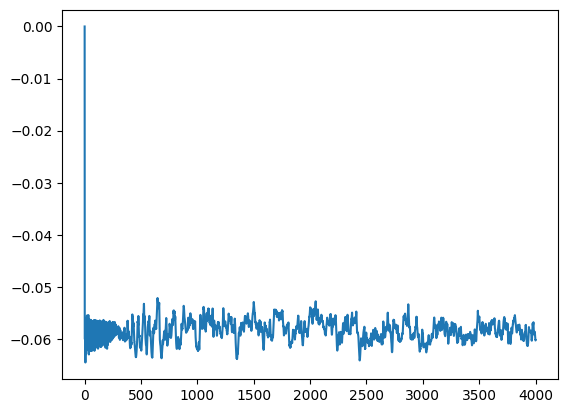

In [23]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
we=0*mV
run(3*simtime, report='text')
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 4*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 6s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 3s
AVG:40.707


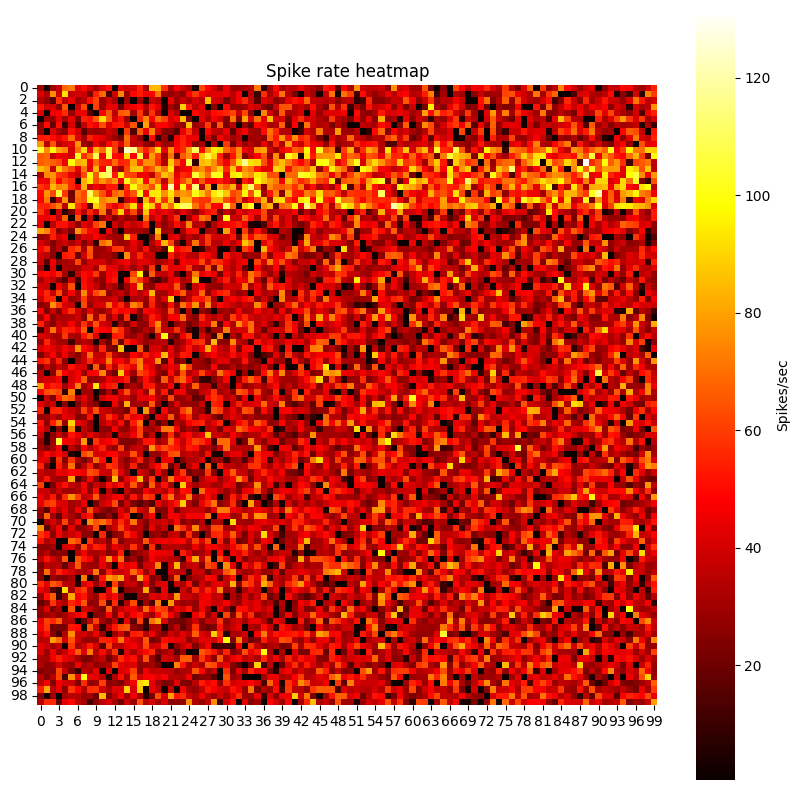

[[30.   3.  30.  ... 30.5 39.  54.5]
 [41.5 33.  75.5 ...  6.  74.  60. ]
 [33.  28.5 15.  ... 52.  35.  40. ]
 ...
 [54.5 81.  34.5 ... 45.5 31.  59. ]
 [24.5  3.  29.  ... 48.  62.5 43.5]
 [33.5 56.  56.  ... 29.  37.5 79.5]]


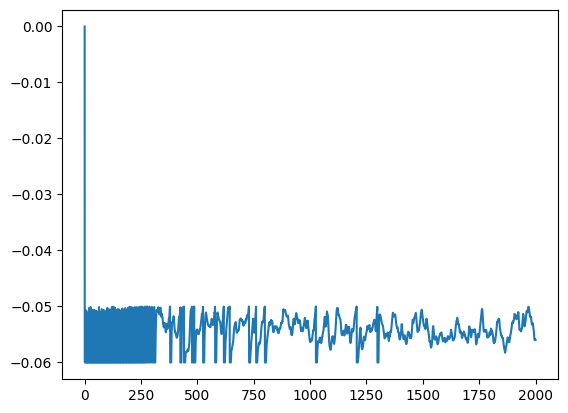

In [24]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

outputrates=[]
sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
outputrates.append(sm.count/simtime)
we=0*mV
sm = SpikeMonitor(neurons)
run(simtime, report='text')
outputrates.append(sm.count/simtime)
# ###########################################
# Make plots
# ###########################################

average_rate = np.mean(outputrates, axis=0)
import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 4*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(average_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(average_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

In [25]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

outputrates=[]
sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
outputrates.append(sm.count/simtime)
we=0*mV
sm = SpikeMonitor(neurons)
run(simtime, report='text')
outputrates.append(sm.count/simtime)
# ###########################################
# Make plots
# ###########################################

average_rate = np.mean(outputrates, axis=0)
import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 4*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(average_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(outputrates[2], (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 6s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 3s
AVG:41.97405


IndexError: list index out of range

4000000
Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 4s
Starting simulation at t=1. s for a duration of 1. s
1. s (100%) simulated in 2s
AVG:38.6855


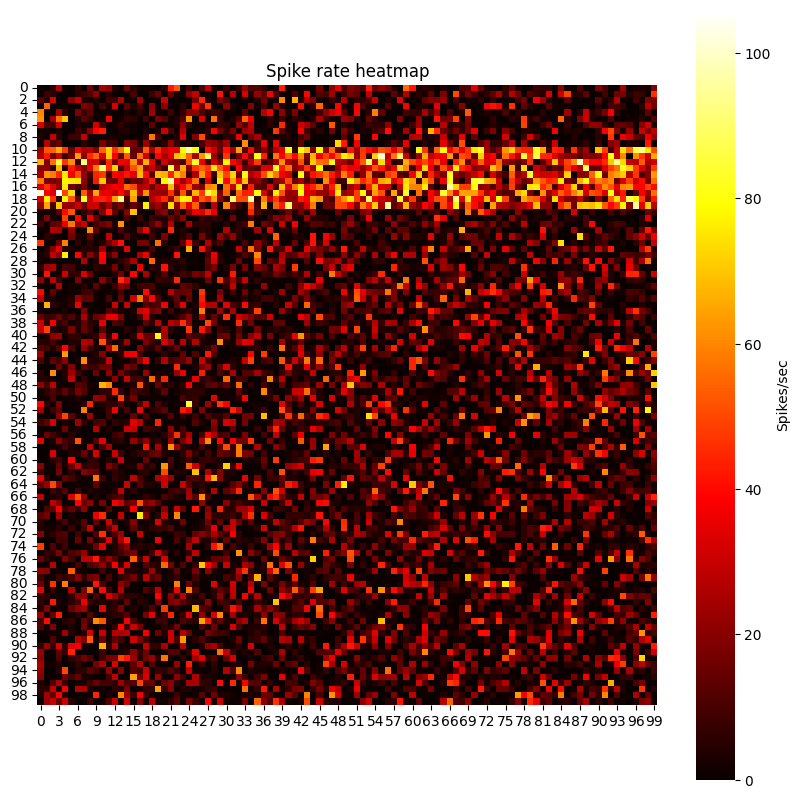

[[ 1.  0.  5. ...  3.  2. 19.]
 [ 0.  8.  5. ...  7.  0. 46.]
 [12.  4. 32. ...  1. 20. 18.]
 ...
 [ 5.  5. 29. ... 47.  0.  5.]
 [ 3. 24. 13. ...  1. 13.  0.]
 [ 0. 23. 29. ... 18. 21.  0.]] Hz


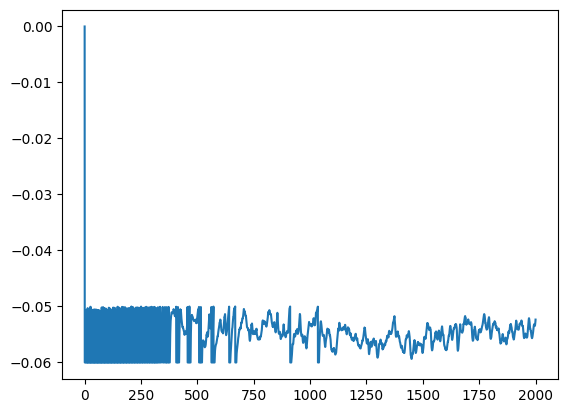

In [26]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
start_scope()
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1000*ms # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
# Randomly permute the indices

indices = np.random.permutation(len(neurons))
# Split the indices into two groups, one with 8000 and one with 2000 neurons

excitatory = indices[:NE]
inhibitory = indices[NE:]
cellassembly=neurons[1000:2000]
# ###########################################
# Connecting the network
# ###########################################

firsta = np.repeat(excitatory, len(neurons.i))
firstab = np.tile(neurons.i, len(excitatory))
con_e = Synapses(neurons, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(i=firsta,j=firstab,p=epsilon)
firsta = np.repeat(inhibitory, len(inhibitory))
firstab = np.tile(inhibitory, len(inhibitory))
print(len(firsta))
con_ii = Synapses(neurons, neurons, on_pre='g_gaba += 3*nS')
con_ii.connect(i=firsta,j=firstab,p=epsilon)
we=0.1*mV
P = PoissonInput(cellassembly, 'v', 100, 100*Hz, weight=we)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
firsta = np.repeat(inhibitory, len(excitatory))
firstab = np.tile(excitatory, len(inhibitory))
con_ie = Synapses(neurons, neurons, model=eqs_stdp_inhib,
                on_pre='''Apre += 1.
                        w = clip(w+(Apost-alpha)*eta, 0, gmax)
                        g_gaba += w*nS''',
                on_post='''Apost += 1.
                        w = clip(w+Apre*eta, 0, gmax)
                    ''')

con_ie.connect(i=firsta, j=firstab,p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

outputrates=[]
sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run with plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(simtime, report='text')
outputrates.append(sm.count/simtime)
we=0*mV
sm = SpikeMonitor(neurons)
run(simtime, report='text')
outputrates.append(sm.count/simtime)
# ###########################################
# Make plots
# ###########################################

average_rate = np.mean(outputrates, axis=0)
import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 4*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(average_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(outputrates[1], (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

In [27]:
from brian2 import *
# ###########################################
# Defining network model parameters
# ###########################################

NE = 8000          # Number of excitatory cells
NI = NE/4          # Number of inhibitory cells
rows, cols = int(np.sqrt(NE+NI)), int(np.sqrt(NE+NI)) # assuming your network is square shaped
tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant
epsilon = 0.02      # Sparseness of synaptic connections
tau_stdp = 20*ms    # STDP time constant
simtime = 1*second # Simulation time
# ###########################################
# Neuron model
# ###########################################

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
er = -80*mV          # Inhibitory reversal potential
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance
bgcurrent = 200*pA   # External current
eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''
# ###########################################
# Initialize neuron group
# ###########################################

neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')

Pe = neurons[:NE]
Pi = neurons[NE:]
# ###########################################
# Connecting the network
# ###########################################

con_e = Synapses(Pe, neurons, on_pre='g_ampa += 0.3*nS')
con_e.connect(p=epsilon)
con_ii = Synapses(Pi, Pi, on_pre='g_gaba += 3*nS')
con_ii.connect(p=epsilon)
# ###########################################
# Inhibitory Plasticity
# ###########################################

eqs_stdp_inhib = '''
w : 1
dApre/dt=-Apre/tau_stdp : 1 (event-driven)
dApost/dt=-Apost/tau_stdp : 1 (event-driven)
'''

alpha = 3*Hz*tau_stdp*2  # Target rate parameter
gmax = 100               # Maximum inhibitory weight
con_ie = Synapses(Pi, Pe, model=eqs_stdp_inhib,
                  on_pre='''Apre += 1.
                         w = clip(w+(Apost-alpha)*eta, 0, gmax)
                         g_gaba += w*nS''',
                  on_post='''Apost += 1.
                          w = clip(w+Apre*eta, 0, gmax)
                       ''')

con_ie.connect(p=epsilon)
con_ie.w = 1e-10
# ###########################################
# Setting up monitors
# ###########################################

sm = SpikeMonitor(neurons)
M = StateMonitor(neurons, 'v', record=0)
# ###########################################
# Run without plasticity
# ###########################################

eta = 1e-2          # Learning rate
run(10*simtime)
# ###########################################
# Make plots
# ###########################################

import seaborn as sns
# Run your network simulation code first
# After running the simulation

spike_counts = sm.count  # This gives the number of spikes for each neuron
spike_rate = spike_counts / 10*simtime  # We ran for 1 second, adjust as needed
print("AVG:"+str(np.average(spike_rate)))# Now let's reshape this into the shape of the network
spike_rate_grid = np.reshape(spike_rate, (rows, cols))
# And plot

plt.figure(figsize=(10,10))
sns.heatmap(spike_rate_grid, square=True, cmap='hot', cbar_kws={'label': 'Spikes/sec'})
plt.title('Spike rate heatmap')
plt.show()
print(spike_rate_grid)
plot(M.t/ms,M.v[0])

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.